### 导入库

In [1]:
import torch
from torch.utils import data
import torchvision
from torchvision import transforms
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import numpy as np

from data import LoadData
from model import VGG16
from utils import *
from loss import EdgeHoldLoss

for name in (torch, torchvision, cv2, np):
    print(name.__version__)

1.6.0+cu101
0.7.0+cu101
4.3.0
1.19.1


### 使用GPU或者CPU

In [2]:
if torch.cuda.is_available():
    device = torch.device(device='cuda')
else:
    device = torch.device(device='cpu')
device

device(type='cuda')

In [3]:
path_image = "./DUTS/DUTS-TR/DUTS-TR-Image/"
path_mask = "./DUTS/DUTS-TR/DUTS-TR-Mask/"

In [4]:
batch_size = 8
learning_rate = 0.001
base_lr = 0.01
target_size = 256
epochs = 100

In [5]:
data_loader = data.DataLoader(LoadData(path_image, path_mask, target_size),
                            batch_size=batch_size,
                            shuffle=True)

In [6]:
total_batch = len(data_loader)
total_batch

1320

### 导入模型

In [7]:
model = VGG16(isDropout=False)

In [8]:
model.load_state_dict(torch.load("./model/PFA_100.pth"), strict=False)

<All keys matched successfully>

In [9]:
model.eval()
model.to(device)
criterion = EdgeHoldLoss(device).to(device)
# criterion = torch.nn.BCELoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0, momentum=0.9)

model.train()

# layers = [model.conv1_1, model.conv1_2, model.conv2_1, model.conv2_2,
#          model.conv3_1, model.conv3_2, model.conv3_3,
#          model.conv4_1, model.conv4_2, model.conv4_3,
#          model.conv5_1, model.conv5_2, model.conv5_3]

# for layer in layers:
#     for par in layer.parameters():
#         par.requires_grad = False
print()

In [10]:
for epoch in range(101, 102):
    criterion = EdgeHoldLoss(device).to(device)
#     criterion = torch.nn.BCELoss().to(device)
    drop = 0.5
    epoch_drop = epochs / 8.
#     learning_rate = base_lr * math.pow(drop, math.floor((1 + epoch) / epoch_drop))
    print("lr: {:.15f}".format(learning_rate))
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=learning_rate,
                                weight_decay=0,
                                momentum=0.9)
    learning_rate = learning_rate - learning_rate * 0.1
    start_time = time.time()
    
    total_loss = 0
    total_acc = 0
    total_pre = 0
    total_rec = 0
    total_f_score = 0
    
    for batch_n, (image, mask) in enumerate(data_loader, start=1):
        
        image = image.to(device)
        mask = mask.to(device)
        
        optimizer.zero_grad()
        predict = model(image)
        loss = criterion(predict, mask)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            total_loss += loss.item()
            acc = accuracy(predict, mask)
            total_acc += acc

            pre = precision(predict, mask)
            total_pre += pre

            rec = recall(predict, mask)
            total_rec += rec

            f_score = F_Measure(pre, rec)
            total_f_score += f_score
        
        
        if batch_n % 100 == 0:
            with torch.no_grad():
                avg_acc = total_acc / batch_n
                avg_pre = total_pre / batch_n
                avg_rec = total_rec / batch_n
                avg_f_score = total_f_score / batch_n
                print("Epoch:{} loss:{} Batch:{}/{}"
                      .format(epoch, loss.item(), batch_n, total_batch), end="")
                print(" acc:{} pre:{} recall:{} F-measure:{}"
                      .format(avg_acc, avg_pre, avg_rec, avg_f_score))
    end_time = time.time()
    print("--------------------------------------------------------------")
    print("Epoch {} time:{:.2f}s END :loss:{} acc:{} pre:{} rec:{} F-measure:{}"
          .format(epoch, 
                  end_time - start_time,
                  total_loss / total_batch, 
                  total_acc / total_batch,
                  total_pre / total_batch,
                  total_rec / total_batch,
                  total_f_score / total_batch))
    print("--------------------------------------------------------------")
    torch.save(model.state_dict(),"./model/PFA_{}.pth".format(epoch))

lr: 0.001000000000000
Epoch:101 loss:0.6518195271492004 Batch:100/1320 acc:0.933788001537323 pre:0.9611235857009888 recall:0.947882890701294 F-measure:0.9578996896743774
Epoch:101 loss:0.6537531614303589 Batch:200/1320 acc:0.9333559274673462 pre:0.962765097618103 recall:0.948463499546051 F-measure:0.959277868270874
Epoch:101 loss:0.6595801115036011 Batch:300/1320 acc:0.9339761734008789 pre:0.9635893106460571 recall:0.947991669178009 F-measure:0.9597902894020081
Epoch:101 loss:0.6602460145950317 Batch:400/1320 acc:0.9340980052947998 pre:0.9635043740272522 recall:0.9472901821136475 F-measure:0.9595490097999573
Epoch:101 loss:0.6664066314697266 Batch:500/1320 acc:0.9342926740646362 pre:0.9638971090316772 recall:0.9470070004463196 F-measure:0.9597830176353455
Epoch:101 loss:0.6567473411560059 Batch:600/1320 acc:0.9345849752426147 pre:0.9639012813568115 recall:0.9464907050132751 F-measure:0.9596600532531738
Epoch:101 loss:0.6519607901573181 Batch:700/1320 acc:0.934848964214325 pre:0.9639013

In [11]:
# torch.save(model.state_dict(),"./model/MPFA_47.pth")

In [12]:
def pad_resize_image(inp_img, out_img=None, target_size=None):
    h, w, c = inp_img.shape
    size = max(h, w)

    padding_h = (size - h) // 2
    padding_w = (size - w) // 2

    if out_img is None:
        # For inference
        temp_x = cv2.copyMakeBorder(inp_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        if target_size is not None:
            temp_x = cv2.resize(temp_x, (target_size, target_size), interpolation=cv2.INTER_AREA)
        return temp_x
    else:
        # For training and testing
        temp_x = cv2.copyMakeBorder(inp_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        temp_y = cv2.copyMakeBorder(out_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        # print(inp_img.shape, temp_x.shape, out_img.shape, temp_y.shape)

        if target_size is not None:
            temp_x = cv2.resize(temp_x, (target_size, target_size), interpolation=cv2.INTER_AREA)
            temp_y = cv2.resize(temp_y, (target_size, target_size), interpolation=cv2.INTER_AREA)
        return temp_x, temp_y


In [13]:
def getInput(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype('float32')
    
    img = pad_resize_image(img, target_size=256)
    img /= 255.
    img = np.transpose(img, axes=(2, 0, 1))
    img = torch.from_numpy(img).float()
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]) 
    
    img = normalize(img)
    return img

In [14]:
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

In [15]:
msk.shape

torch.Size([256, 256, 1])

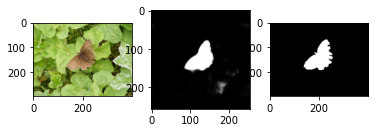

In [16]:
img = getInput("./DUTS/DUTS-TE/DUTS-TE-Image/ILSVRC2012_test_00000025.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./DUTS/DUTS-TE/DUTS-TE-Image/ILSVRC2012_test_00000025.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(msk, cmap='gray')
mask = cv2.imread("./DUTS/DUTS-TE/DUTS-TE-Mask/ILSVRC2012_test_00000025.png")
plt.subplot(133)
plt.imshow(mask, cmap='gray')
plt.show()

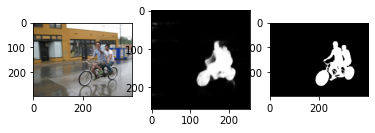

In [17]:
img = getInput("./DUTS/DUTS-TE/DUTS-TE-Image/ILSVRC2012_test_00000023.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./DUTS/DUTS-TE/DUTS-TE-Image/ILSVRC2012_test_00000023.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(msk, cmap='gray')
mask = cv2.imread("./DUTS/DUTS-TE/DUTS-TE-Mask/ILSVRC2012_test_00000023.png")
plt.subplot(133)
plt.imshow(mask, cmap='gray')
plt.show()

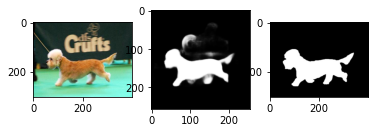

In [18]:
img = getInput("./DUTS/DUTS-TE/DUTS-TE-Image/ILSVRC2012_test_00000003.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./DUTS/DUTS-TE/DUTS-TE-Image/ILSVRC2012_test_00000003.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(msk, cmap='gray')
mask = cv2.imread("./DUTS/DUTS-TE/DUTS-TE-Mask/ILSVRC2012_test_00000003.png")
plt.subplot(133)
plt.imshow(mask, cmap='gray')
plt.show()